In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

OUTPUT_DIR = "./output_origin"
excluded = ['Lang-2', 'Time-21', 'Closure-63', 'Closure-93']
path_to_figure2 = "./Figure_2.pdf"
path_to_table2 = "./Table_2.md"

/home/user/.conda/envs/fdg/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def json_to_dataframe(path, num_iters=10):
    with open(path, 'r') as jsonfile:
        data = json.load(jsonfile)

    rows = []
    for program in data:
        if not data[program]:
            # if empty
            continue
        num_faililing_tests = len(data[program])
        for test_index, s_data in enumerate(data[program]):
            if "full_ranks" not in s_data:
                continue
            full_ranks = np.array(s_data["full_ranks"])
            ranks = np.array(s_data["ranks"])
            fitnesses = s_data["fitness_history"]
            if ranks.shape[0] < num_iters + 1:
                ranks = np.repeat(ranks,
                    [1] * (ranks.shape[0] - 1) \
                    + [num_iters - ranks.shape[0] + 2],
                    axis=0)
                assert ranks.shape[0] == num_iters + 1
            for i in range(num_iters + 1):
                fitness = fitnesses[i] if i < len(fitnesses) else None
                for j in range(ranks.shape[1]):
                    rows.append(
                        [program, int(i), int(full_ranks[j]), int(ranks[i,j]),
                        fitness, num_faililing_tests, test_index]
                    )

    df = pd.DataFrame(data=rows, columns=['program', 'iteration', 'full_rank',
        'rank', 'fitness', 'num_failing_tests', 'failing_test_index'])
    return df

In [3]:
import os
dfs = {}

for fname in os.listdir(OUTPUT_DIR):
    if fname[-5:] == ".json":
        metric = fname[:-5]
        fpath = os.path.join(OUTPUT_DIR, fname)
        print(fname)
        df = json_to_dataframe(fpath, num_iters=10)
        df = df[~df.program.isin(excluded)]
        # print(len(df.loc[df["program"]=="Chart-2"]))
        dfs[metric] = df

print(f"# diagnosability metrics: {len(dfs)}")
print(f"# subjects: {dfs['FDG']['program'].unique().shape}")

Add.json
Cover.json
DDU.json
EntBug.json
FDG.json
FLINT.json
Prox.json
RAPTER.json
S3.json
Split.json
TfD.json
Total.json
RLFDC.json
# diagnosability metrics: 13
# subjects: (351,)


# Figure 2 - mAP comparison

In [4]:
def plot_mAP(dfs, metrics, categories=None, colors=None,
    figsize=None, savepath=None):

    df = pd.concat(
        [dfs[metric] for metric in metrics],
        keys=metrics
    )
    df["metric"] = df.index.get_level_values(level=0)
    plt.figure(figsize=(8,6) if figsize is None else figsize)

    df["rank"] = df["rank"].astype(np.float64)
    # print(df) ###### 
    # compute relative rank order among relevant ones
    order = df.groupby(
        ["program", "metric", "iteration", "failing_test_index"]
    )["rank"].rank(ascending=True, method="max")
    # print(order) #### 
    df["precision"]  = order/df["rank"]
    AP = df.groupby(["program", "metric", "iteration"]).mean()
    mAP = AP.groupby(["metric", "iteration"]).mean()["precision"]
    mAP = mAP.reset_index()
    mAP.rename(columns={"precision": "mAP"}, inplace=True)

    plot_args = {}
    
    if categories:
        for m in metrics:
            mAP.loc[mAP.metric == m, "category"] = categories[m]
        plot_args["style"] = "category"
    if colors:
        plot_args["palette"] = [colors[m] for m in metrics]
    
    # plot_args["dashes"] = []

    # sns.lineplot(
    #     data=mAP, 
    #     x="iteration",
    #     y="mAP", 
    #     hue="metric", # different colors by group
    #     hue_order=metrics,
    #     legend='auto',
    #     zorder=3,
    #     **plot_args
    # )      

    for m in metrics:
        if m == "FDG":
            plt.plot(range(0,11), mAP.loc[mAP.metric == m]['mAP'].values, label = m, color="grey",linestyle=(0,(5,6)))
        elif m == "RLFDA":
            plt.plot(range(0,11), mAP.loc[mAP.metric == m]['mAP'].values, label = m, color = "red")
        else:
            plt.plot(range(0,11), mAP.loc[mAP.metric == m]['mAP'].values, label = m)
    # plt.plot(x, y6, label = 'RankNet')
    # plt.plot(x, y7, label = 'Rankboost')
    # plt.plot(x, y8, label = 'CA')
    # plt.plot(x, y9, label = 'L-MART')
    # plt.plot(x, y1, label = 'RL')
    # plt.plot(x, y2, label = 'RL-MLP')
    # plt.plot(x, y4, label = 'ACER-PA')

    plt.legend(loc=(0.98,0.1))
    plt.xlabel("Iteration")
    plt.ylabel("mAP")
    plt.ylim(0.07, mAP["mAP"].max() + 0.01)
    plt.grid(color='lightgrey', zorder=0)
    plt.xticks(range(0, int(mAP['iteration'].max() + 1)))

    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()
    return mAP

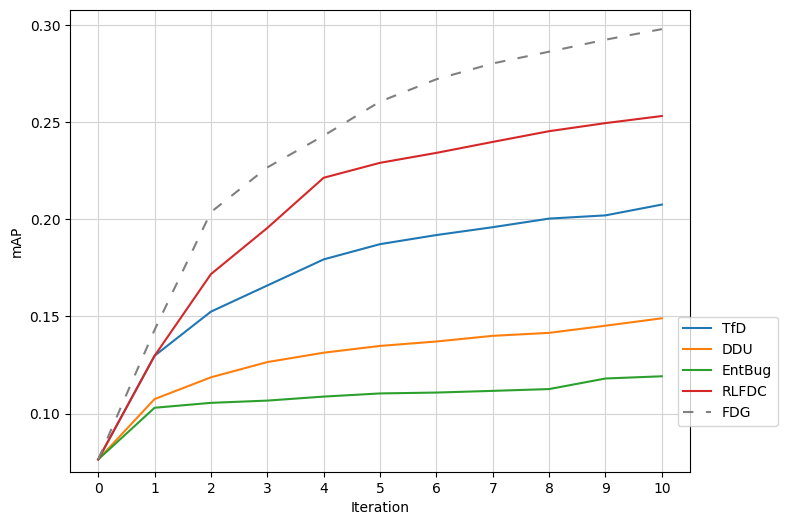

    metric  iteration       mAP         category
10     DDU         10  0.149063  Result_agnostic
21  EntBug         10  0.119184  Result_agnostic
32     FDG         10  0.298088     Result_aware
43   RLFDC         10  0.253305  Result_agnostic
54     TfD         10  0.207670  Result_agnostic
Saved to ./Figure_2.pdf


In [5]:
plot_data = [
    # metric, category, color
    # ("S3"    , "Result_aware",    (0.00, 0.70, 0.99)),
    # ("Prox"  , "Result_aware",    (0.50, 0.90, 0.00)),
    ("TfD"   , "Result_agnostic", (0.80, 0.10, 0.70)),
    # ("RAPTER", "Result_agnostic", (0.29, 0.18, 0.40)),
    # ("Add"   , "Result_agnostic", (0.09, 0.60, 0.45)),
    ("DDU"   , "Result_agnostic", (0.77, 0.15, 0.31)),
    # ("Total" , "Result_agnostic", (0.99, 0.50, 0.00)),
    ("EntBug", "Result_agnostic", (0.99, 0.50, 0.00)),
    # ("FLINT" , "Result_aware",    (0.55, 0.60, 0.68)),
    ("RLFDC" , "Result_agnostic",  (0.10, 0.70, 0.70)),
    ("FDG" , "Result_aware",      (0.60, 0.60, 0.60))
]
mAP=plot_mAP(dfs,
    metrics=[m for m, _, _ in plot_data],
    categories={m:ca for m, ca, _ in plot_data},
    # categories=None,
    colors={m:co for m, _, co in plot_data},
    savepath=path_to_figure2
)
print(mAP.loc[mAP["iteration"]==10])
print(f"Saved to {path_to_figure2}")

# Table 2 - acc@n comparison

In [6]:
def get_highest_ranks(df):
    return df.groupby(  # because a program may contain multiple methods, so perform min() to get the best ranked method at each iteration
        ['program', 'iteration', 'failing_test_index']
    ).min()[['full_rank', 'rank']].reset_index()

def accuracy_at(df, iteration, n, column='rank'):
    mdf = df[df.iteration == iteration].copy()
    mdf[f"acc@{n}"] = mdf[column] <= n
    grouped = mdf.groupby('program').mean()[f"acc@{n}"]  # average the acc@n for each failing test, here the program=project-version
    return int(round(grouped.sum(), 0)) # sum all the program and round

def get_acc_n_table(dfs, N=[1,3,5,10], num_iters=10):
    rows = []
    for metric in dfs:
        frame = get_highest_ranks(dfs[metric])
        for iteration in range(0, num_iters+1):
            row = [metric, iteration]
            for n in N:
                value = accuracy_at(frame, iteration, n)
                row.append(value)
            rows.append(row)
        row = [metric, "Full"]
        for n in N:
            row.append(accuracy_at(frame, 0, n, column="full_rank"))
        rows.append(row)

    df = pd.DataFrame(data=rows,
        columns=["metric", "iteration"] + [f"acc@{n}" for n in N])
    return df

In [8]:
N = [1,3,5,10]
num_iters = 10
df = get_acc_n_table(dfs, N=N, num_iters=num_iters)

upper_row= ["EntBug", "Total", "DDU", "Add", "RAPTER", "TfD"]
lower_row = ["FLINT", "Prox", "S3", "Split", "Cover", "FDG", "RLFDC"]

markdown = ""
markdown += f"# Table 2\n"
for metric in upper_row:
    markdown += f"## {metric}\n"
    markdown += df[df.metric == metric][["iteration"] + [f"acc@{n}" for n in N]].to_markdown(index=False)
    markdown += "\n"
for metric in lower_row:
    markdown += f"## {metric}\n"
    markdown += df[df.metric == metric][["iteration"] + [f"acc@{n}" for n in N]].to_markdown(index=False)
    markdown += "\n"

with open(path_to_table2, "w") as f:
    f.write(markdown)

print(f"Saved to {path_to_table2}")
print(markdown)

Saved to ./Table_2.md
# Table 2
## EntBug
| iteration   |   acc@1 |   acc@3 |   acc@5 |   acc@10 |
|:------------|--------:|--------:|--------:|---------:|
| 0           |       4 |      30 |      45 |       65 |
| 1           |       9 |      40 |      61 |       80 |
| 2           |       9 |      41 |      63 |       85 |
| 3           |       9 |      40 |      64 |       90 |
| 4           |       9 |      40 |      64 |       94 |
| 5           |       9 |      41 |      67 |       95 |
| 6           |       9 |      41 |      67 |       96 |
| 7           |       9 |      41 |      68 |       96 |
| 8           |       9 |      41 |      68 |       99 |
| 9           |      11 |      43 |      68 |       99 |
| 10          |      12 |      44 |      68 |      101 |
| Full        |     110 |     208 |     250 |      277 |
## Total
| iteration   |   acc@1 |   acc@3 |   acc@5 |   acc@10 |
|:------------|--------:|--------:|--------:|---------:|
| 0           |       4 |      30 |  